# Source Model

In [1]:
import pandas as pd
import numpy as np
import ast
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.base import clone

In [2]:
# Imputation
from transformers.features_missing_vals import imputation_pipeline
from transformers.filter_columns import FilterColumns

In [3]:
# Univariate analysis
from univariate.vis_relationships_with_y import plot_dropout_rate
from univariate.calc_univariate_AUC import univariate_auc

In [4]:
# Multivariate Analysis
from multivariate.models_list import create_list_of_models
from multivariate.model_selection import cross_validate_AUC_entropy
from multivariate.model_selection import check_model_signs
from multivariate.model_selection import plot_cv_selected_models

from model_evaluation.metrics import fit_test_model

from fairness.customized_entropy import calc_educ_rank_benefits

# Params

In [5]:
source_school = 'ULSA'

In [6]:
random_state = 1

In [7]:
clf_model = LogisticRegression(penalty=None, random_state=random_state, max_iter=10000)

# Data Loading

In [8]:
features_df = pd.read_csv('features_df.csv', low_memory=False)
source_df = features_df[features_df['PRMRY_CRER_CD']==source_school].copy()

# Train Test samples

In [9]:
sample_train, sample_test = train_test_split(source_df, test_size=0.3, random_state=random_state)

In [ ]:
# Dropout rate train sample
# Cell outputs are cleared to prevent information disclosure
sample_train['y_ENROLLED_1_YEAR_LATER'].mean()

In [ ]:
# Dropout rate test sample
# Cell outputs are cleared to prevent information disclosure
sample_test['y_ENROLLED_1_YEAR_LATER'].mean()

In [12]:
# Impute missing values and WoE for categorical features
sample_train_imp = imputation_pipeline.fit_transform(sample_train, sample_train['y_ENROLLED_1_YEAR_LATER'])

# Univariate Analysis for the Source School

### Exploring relationships between response and independent variables
Cell outputs are cleared to prevent information disclosure

In [ ]:
plot_dropout_rate(sample_train, 'STDNT_AGE_BIN', 'Student Age')

In [ ]:
plot_dropout_rate(sample_train, 'HS_GPA_BIN', 'High school GPA', rotate=True)

In [ ]:
plot_dropout_rate(sample_train, 'CURR_GPA_BIN', 'Current GPA', rotate=True)

In [ ]:
plot_dropout_rate(sample_train, 'HS_CALC_IND', 'High School Calculus')
# 1 - Student completed High School Calculus

In [ ]:
plot_dropout_rate(sample_train, 'GROSS_FAM_INC', 'Gross Family income', sort=True, rotate=True)

In [ ]:
plot_dropout_rate(sample_train, 'SNGL_PRNT_IND', 'Single parent')

In [ ]:
dic = {1: 'White', 2: 'Black', 3: 'Hispanic', 
       4: 'Asian', 5: 'Native Amr\nHawaiian', 6: 'Not Indic', 
       7: 'Hawaiian', 0: '2 or More'}
plot_dropout_rate(sample_train, 'STDNT_ETHNC_GRP_CD', 'Ethnicity', sort=True, rotate=True, dic=dic)

In [ ]:
plot_dropout_rate(sample_train, 'SAT_TOTAL_BIN', 'SAT', rotate=True)

In [ ]:
plot_dropout_rate(sample_train, 'SAT_ACT_TOTAL_BIN', 'SAT, imputing missing values with ACT', rotate=True)

In [ ]:
plot_dropout_rate(sample_train, 'PRNT_ED_LVL', 'Parent Education Level', sort=True, rotate=True)

In [ ]:
plot_dropout_rate(sample_train, 'ACAD_LOAD', 'Academic Load', sort=True)

In [ ]:
plot_dropout_rate(sample_train, 'No_grades_at_all', 'Absence of course grade data')

In [ ]:
plot_dropout_rate(sample_train, 'Grade_I_num_of_courses', 'Grade Incomplete')

In [ ]:
plot_dropout_rate(sample_train, 'Grade_II_num_of_courses', 'Incomplete courses that were finished')

In [ ]:
plot_dropout_rate(sample_train, 'Grade_Overall_I_num_of_courses', 'All incomplete courses finished/unfinished')

In [ ]:
plot_dropout_rate(sample_train, 'Grade_W_num_of_courses', 'Official Withdrawals')

In [ ]:
plot_dropout_rate(sample_train, 'Grade_Y_num_of_courses', "Grade 'Y' (work in progress)")

In [ ]:
plot_dropout_rate(sample_train, 'Grade_NR_num_of_courses', "Grade 'NR' (student stops attending)")

## Univariate AUC

### Group of factors

In [31]:
# Factors
factors = ['STDNT_FEMALE', 
           'STDNT_AGE_BIN',
           'HS_GPA_BIN', ['HS_GPA_IsMissing', 'HS_GPA_Imp'], 'HS_GPA_Imp_Interp',
           'CURR_GPA', 'CURR_GPA_BIN',
           'HS_CALC_IND',
           'GROSS_FAM_INC','SNGL_PRNT_IND',
           'STDNT_ETHNC_GRP_CD', ['STDNT_ASIAN_IND', 'STDNT_BLACK_IND', 'STDNT_HSPNC_IND', 
                                  'STDNT_NTV_AMRCN_HWIAN_IND', 'STDNT_MULTI_ETHNC_IND', 'STDNT_ETHNC_NAN'],
           'SAT_ACT_TOTAL_BIN', 
           ['SAT_ACT_TOTAL_SCR_IsMissing', 'SAT_ACT_TOTAL_SCR_Imp'], 'SAT_ACT_TOTAL_SCR_Imp_Interp', 
           ['ACT_SAT_TOTAL_SCR_IsMissing', 'ACT_SAT_TOTAL_SCR_Imp'], 
           ['ACT_SAT_MATH_PCTL_IsMissing', 'ACT_SAT_MATH_PCTL_Imp'],  
           ['SAT_ACT_MATH_PCTL_IsMissing', 'SAT_ACT_MATH_PCTL_Imp'], 
           'PRNT_ED_LVL', 'ACAD_LOAD',
           'No_grades_at_all', 
           'Grade_Overall_I_for_1_and_more_courses',
           ['Grade_W_for_1_course', 'Grade_W_for_2_courses', 'Grade_W_for_3_and_more_courses'],
           'Grade_NR_for_1_and_more_courses'
           ]

# Corresponding groups
factors_group = ['GENDER', 'AGE', 'HS_GPA', 'HS_GPA', 'HS_GPA', 'CURR_GPA', 'CURR_GPA',
                 'HS_CALCULUS', 'FAMILY_INCOME', 'SINGLE_PARENT', 'ETHNICITY', 'ETHNICITY',
                 'SAT', 'SAT', 'SAT', 'SAT', 
                 'SAT_MATH', 'SAT_MATH', 
                 'PARENT_EDUCATION', 'ACAD_LOAD',
                 'WARNING_SIGNALS', 'WARNING_SIGNALS', 'WARNING_SIGNALS', 'WARNING_SIGNALS']

In [32]:
d = {'Group': factors_group, 'Factor': factors}
factors_df = pd.DataFrame(data=d)

In [33]:
factors_df

,Group,Factor
0,GENDER,STDNT_FEMALE
1,AGE,STDNT_AGE_BIN
2,HS_GPA,HS_GPA_BIN
3,HS_GPA,"[HS_GPA_IsMissing, HS_GPA_Imp]"
4,HS_GPA,HS_GPA_Imp_Interp
5,CURR_GPA,CURR_GPA
6,CURR_GPA,CURR_GPA_BIN
7,HS_CALCULUS,HS_CALC_IND
8,FAMILY_INCOME,GROSS_FAM_INC
9,SINGLE_PARENT,SNGL_PRNT_IND


### Signs of factors

In [34]:
def flatten_list(factors_list):
    """
    Flattens a list that may contain other nested lists.
    E.g., a list [a, [b, c], d] will be flattened to [a, b, c, d].
    
    Args:
    factors_list (List) - List that requires flattening
    
    Returns:
    flattened_list (List) - Flattened list
    """
    flattened_list = []
    
    for factor in factors_list:
        if type(factor)==list:
            for subfactor in factor:
                flattened_list.append(subfactor)
        else:
            flattened_list.append(factor)
            
            
    return flattened_list

In [35]:
# Define the correct signs of factors' coefficients.
# 1 indicates that a higher value of the factor corresponds to a higher dropout probability
# -1 indicates that a higher value of the factor corresponds to a lower dropout probability
# NaN denotes that the sign of the relationship cannot be determined based on general logic

signs = [np.NaN, 1, 1, np.NaN, -1, -1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, np.NaN, np.NaN, 
         1, np.NaN, -1, -1, np.NaN, -1, np.NaN, -1, np.NaN, -1, 1, 1, 1, 1, 1, 1, 1, 1]

In [36]:
# DataFrame that specifies the correct sign for each factor
d = {'Factor': flatten_list(factors), 'Coef_sign': signs}
factors_sign_df = pd.DataFrame(data=d)

In [37]:
factors_sign_df

,Factor,Coef_sign
0,STDNT_FEMALE,NaN
1,STDNT_AGE_BIN,1.0
2,HS_GPA_BIN,1.0
3,HS_GPA_IsMissing,NaN
4,HS_GPA_Imp,-1.0
5,HS_GPA_Imp_Interp,-1.0
6,CURR_GPA,-1.0
7,CURR_GPA_BIN,1.0
8,HS_CALC_IND,-1.0
9,GROSS_FAM_INC,1.0


### Univariate AUC

In [38]:
# Calculate univariate AUC for individual factors
factors_df = univariate_auc(sample_train_imp, factors_df, clone(clf_model)) 

In [39]:
factors_df

,Group,Factor,AUC
0,GENDER,STDNT_FEMALE,0.525027
1,AGE,STDNT_AGE_BIN,0.525073
2,HS_GPA,HS_GPA_BIN,0.539520
3,HS_GPA,"[HS_GPA_IsMissing, HS_GPA_Imp]",0.539367
4,HS_GPA,HS_GPA_Imp_Interp,0.539399
5,CURR_GPA,CURR_GPA,0.717204
6,CURR_GPA,CURR_GPA_BIN,0.716923
7,HS_CALCULUS,HS_CALC_IND,0.583761
8,FAMILY_INCOME,GROSS_FAM_INC,0.608133
9,SINGLE_PARENT,SNGL_PRNT_IND,0.570776


# Multivariate Analysis for the Source School

## List of possible models

The list of models is created by considering all possible combinations of the factors.

In [ ]:
# Specify possible groups where a factor from each possible group may or may not be included in a model. 
# Models will be generated that incorporate a factor from a certain possible group, as well as 
# models that exclude a factor from this group.
possible_groups =['GENDER', 'AGE', 'HS_GPA', 'CURR_GPA', 'HS_CALCULUS', 
                  'FAMILY_INCOME', 'SINGLE_PARENT', 'ETHNICITY', 
                  'SAT', 'SAT_MATH', 'PARENT_EDUCATION', 'ACAD_LOAD'] 

# Specify specific groups wherein a factor from each such group is mandatory and must be included in all the models
groups_to_include = ['CURR_GPA']

# Dataframe containing all the possible models
models = create_list_of_models(possible_groups, groups_to_include, factors_df)

In [41]:
# Number of models
len(models)

46080

In [42]:
# First model from the list of all possible models
models.loc[0, 'MODEL']

['STDNT_FEMALE',
 'STDNT_AGE_BIN',
 'HS_GPA_BIN',
 'CURR_GPA',
 'HS_CALC_IND',
 'GROSS_FAM_INC',
 'SNGL_PRNT_IND',
 'STDNT_ETHNC_GRP_CD',
 'SAT_ACT_TOTAL_BIN',
 'ACT_SAT_MATH_PCTL_IsMissing',
 'ACT_SAT_MATH_PCTL_Imp',
 'PRNT_ED_LVL',
 'ACAD_LOAD',
 'No_grades_at_all',
 'Grade_Overall_I_for_1_and_more_courses',
 'Grade_W_for_1_course',
 'Grade_W_for_2_courses',
 'Grade_W_for_3_and_more_courses',
 'Grade_NR_for_1_and_more_courses']

## Examining the signs of coefficients in models

In [43]:
clf = clone(clf_model)

In [ ]:
# Check the signs of coefficients in models
models_sign = check_model_signs(models, factors_sign_df, clf, sample_train_imp)

In [153]:
models_sign.to_csv('models_sign.csv', index=False)

In [44]:
models_sign = pd.read_csv('models_sign.csv')

In [45]:
# The number of models having correct coefficients' signs
models_sign['Correct_signs'].sum()

13931.0

In [46]:
# Models with the correct coefficients' signs
models_filtered = models_sign.loc[models_sign['Correct_signs']==1, 'MODEL']
models_filtered = models_filtered.reset_index()
models_filtered

,index,MODEL
0,8,"['STDNT_FEMALE', 'STDNT_AGE_BIN', 'HS_GPA_BIN'..."
1,9,"['STDNT_FEMALE', 'STDNT_AGE_BIN', 'HS_GPA_BIN'..."
2,10,"['STDNT_FEMALE', 'STDNT_AGE_BIN', 'HS_GPA_BIN'..."
3,11,"['STDNT_FEMALE', 'STDNT_AGE_BIN', 'HS_GPA_BIN'..."
4,20,"['STDNT_FEMALE', 'STDNT_AGE_BIN', 'HS_GPA_BIN'..."
...,...,...
13926,46071,"['CURR_GPA_BIN', 'ACT_SAT_MATH_PCTL_IsMissing'..."
13927,46075,"['CURR_GPA_BIN', 'SAT_ACT_MATH_PCTL_IsMissing'..."
13928,46076,"['CURR_GPA_BIN', 'PRNT_ED_LVL', 'ACAD_LOAD', '..."
13929,46077,"['CURR_GPA_BIN', 'PRNT_ED_LVL', 'No_grades_at_..."


## Cross-validating models that have correct coefficient signs

In [47]:
# The first model for cross-validation
model = models_filtered.loc[0, 'MODEL']
model = ast.literal_eval(model)

clf = clone(clf_model)

pipeline = Pipeline(steps=[("imputation", imputation_pipeline), # impute missing values and apply WoE transformation
                           ("filter_columns", FilterColumns(model)),
                           ("logistic_regression", clf)])

In [48]:
pipeline

Pipeline(steps=[('imputation',
                 Pipeline(steps=[('missing_values',
                                  ImputeMissing(cols=['HS_GPA',
                                                      'SAT_ACT_TOTAL_SCR',
                                                      'ACT_SAT_TOTAL_SCR',
                                                      'ACT_SAT_MATH_PCTL',
                                                      'SAT_ACT_MATH_PCTL'],
                                                dic={'HS_GPA': 'HS_GPA_BIN',
                                                     'SAT_ACT_TOTAL_SCR': 'SAT_ACT_TOTAL_BIN'})),
                                 ('encoder_WoE',
                                  WOEEncoder(cols=['STDNT_AGE_BIN',
                                                   'HS_GPA_BIN', 'CURR_GPA_BIN',
                                                   'STDNT_ETHNC_GRP_CD',
                                                   'GROSS_FA...
                                                'HS_CALC_IND', 'GROSS_FAM_INC',
                                                'SNGL_PRNT_IND',
                                                'STDNT_ETHNC_GRP_CD',
                                                'SAT_ACT_TOTAL_BIN',
                                                'PRNT_ED_LVL', 'ACAD_LOAD',
                                                'No_grades_at_all',
                                                'Grade_Overall_I_for_1_and_more_courses',
                                                'Grade_W_for_1_course',
                                                'Grade_W_for_2_courses',
                                                'Grade_W_for_3_and_more_courses',
                                                'Grade_NR_for_1_and_more_courses'])),
                ('logistic_regression',
                 LogisticRegression(max_iter=10000, penalty=None,
                                    random_state=1))])

In [ ]:
# Conduct cross-validation using the pipeline defined in the cell above. 
# The resulting scores are AUC and generalized entropy index.

# Splitting models into groups of 100 accelerates the calculation process 

i1=0
i2=100
num = 100
for file_ind in range(140):
    models_cv_res = cross_validate_AUC_entropy(sample_train, models_filtered[i1:i2], 3, pipeline,
                                               2, calc_educ_rank_benefits, [90, 95, 97, 99, 99.5])
    file_name = 'models/models_cv_res_' + str(i1) + "-" +str(i2) + ".csv" 
    models_cv_res.to_csv(file_name)
    i1 += num
    i2 += num

In [49]:
# Results of the cross-validation
files = ! ls models/*.csv

# DataFrame to concatenate coss-validation results from different files
models_cv_res = None

for file in files:
    model_cv_res = pd.read_csv(file)
    if type(models_cv_res)==pd.core.frame.DataFrame:
        models_cv_res = pd.concat([models_cv_res, model_cv_res])
    else:
        models_cv_res = model_cv_res.copy()

models_cv_res = models_cv_res.sort_values(by='Unnamed: 0')
models_cv_res.reset_index(drop=True, inplace=True)
models_cv_res.drop(columns=['Unnamed: 0'], inplace=True)
models_cv_res = models_cv_res.sort_values(by='test_AUC_mean', ascending=False)

models_cv_res

,index,MODEL,test_AUC_mean,test_AUC_se,train_AUC_mean,test_Gen entropy_mean,test_Gen entropy_se
3638,11951,"['STDNT_FEMALE', 'HS_GPA_BIN', 'CURR_GPA', 'HS...",0.777052,0.004040,0.790581,0.704837,0.008658
3637,11950,"['STDNT_FEMALE', 'HS_GPA_BIN', 'CURR_GPA', 'HS...",0.776946,0.004007,0.790672,0.702772,0.007776
3620,11891,"['STDNT_FEMALE', 'HS_GPA_BIN', 'CURR_GPA', 'HS...",0.776623,0.005969,0.787583,0.700814,0.006185
6264,20590,"['STDNT_FEMALE', 'CURR_GPA', 'HS_CALC_IND', 'S...",0.776619,0.004701,0.789147,0.708816,0.012702
6265,20591,"['STDNT_FEMALE', 'CURR_GPA', 'HS_CALC_IND', 'S...",0.776616,0.004747,0.789133,0.710496,0.013209
...,...,...,...,...,...,...,...
7000,23039,"['STDNT_FEMALE', 'CURR_GPA_BIN', 'No_grades_at...",0.717666,0.004425,0.731719,0.782454,0.013033
13926,46071,"['CURR_GPA_BIN', 'ACT_SAT_MATH_PCTL_IsMissing'...",0.717092,0.014975,0.740479,0.757320,0.022796
10461,34551,"['STDNT_AGE_BIN', 'CURR_GPA_BIN', 'ACT_SAT_MAT...",0.716128,0.019004,0.749507,0.751850,0.019208
10466,34559,"['STDNT_AGE_BIN', 'CURR_GPA_BIN', 'No_grades_a...",0.716071,0.011205,0.740767,0.771017,0.013713


### Distribution of cross-validation results

In [50]:
models_cv_res.describe().iloc[:, 1:]

,test_AUC_mean,test_AUC_se,train_AUC_mean,test_Gen entropy_mean,test_Gen entropy_se
count,13931.000000,13931.000000,13931.000000,13931.000000,13931.000000
mean,0.760199,0.008879,0.784077,0.703034,0.027440
std,0.007137,0.003634,0.008441,0.021638,0.010198
min,0.713118,0.000086,0.727541,0.642824,0.000038
25%,0.756560,0.006342,0.779735,0.687617,0.020879
50%,0.761065,0.008954,0.785190,0.702021,0.027647
75%,0.764982,0.011432,0.789797,0.717668,0.034182
max,0.777052,0.019178,0.801691,0.792055,0.067567


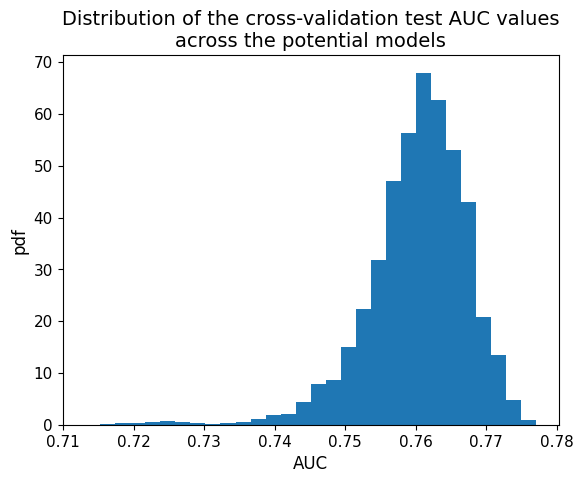

In [51]:
plt.hist(models_cv_res['test_AUC_mean'], bins=30, density=True)
plt.title('Distribution of the cross-validation test AUC values\nacross the potential models', 
          fontsize=14)
plt.xlabel('AUC', fontsize=12)
plt.ylabel('pdf', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11);

### The top 1000 models based on their test AUC values

In [52]:
# Define the 1000 best models
num_best_models = 1000
models_cv_res['best_model'] = np.NaN
models_cv_res.head(num_best_models).index
models_cv_res['best_model'] = np.where(models_cv_res.index.isin(models_cv_res.head(num_best_models).index), 
                                       'top '+str(num_best_models)+'\nmodels',
                                       'remaining\nmodels')

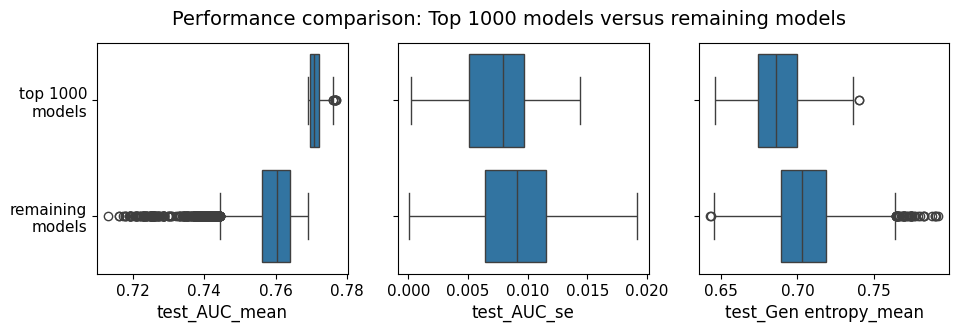

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(11, 3))
sns.boxplot(data=models_cv_res, x="test_AUC_mean", y="best_model", ax=axes[0])
sns.boxplot(data=models_cv_res, x="test_AUC_se", y="best_model", ax=axes[1])
sns.boxplot(data=models_cv_res, x="test_Gen entropy_mean", y="best_model", ax=axes[2])
plt.suptitle(f'Performance comparison: Top {num_best_models} models versus remaining models', 
             fontsize=14, y=0.99)

for ind in range(3):
    axes[ind].set(ylabel=None)
    axes[ind].tick_params(axis='both', which='major', labelsize=11)
    axes[ind].xaxis.get_label().set_fontsize(12)
    
    if ind > 0:
        axes[ind].set(yticklabels=[])
        
fig.subplots_adjust(hspace=10)        

In [54]:
models_best = models_cv_res.head(num_best_models).copy()

In [55]:
models_best = models_best.merge(models, how='left', left_on='index', right_index=True)

#### Frequency of factor groups within the top 1000 models

In [56]:
factor_groups = models.columns[:-2]
bar_stats = models_best[factor_groups].count()
bar_stats.sort_values(ascending=False, inplace=True)

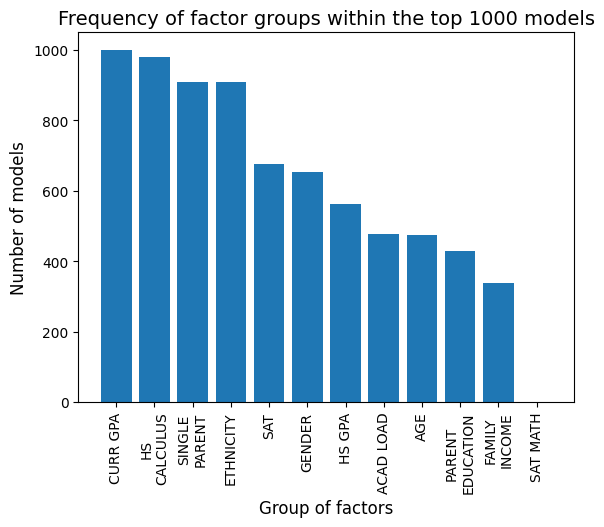

In [57]:
xlabels = ['CURR GPA', 'HS\nCALCULUS', 'SINGLE\nPARENT', 'ETHNICITY', 'SAT',
           'GENDER', 'HS GPA', 'ACAD LOAD', 'AGE', 'PARENT\nEDUCATION',
           'FAMILY\nINCOME', 'SAT MATH']
plt.bar(xlabels, bar_stats)
plt.xlabel('Group of factors', fontsize=12)
plt.ylabel('Number of models', fontsize=12)
plt.title(f'Frequency of factor groups within the top {num_best_models} models', fontsize=14)
plt.xticks(rotation=90);

## Selecting models for subsequent analysis

In [58]:
# List of models for further analysis
model_indices = []

In [59]:
models_cv_res_ = models_cv_res.merge(models, how='left', left_on='index', right_index=True)

In [60]:
# The best 5 models chosen by test AUC
pd.set_option('display.max_columns', None)
models_cv_res_.head()

,index,MODEL_x,test_AUC_mean,test_AUC_se,train_AUC_mean,test_Gen entropy_mean,test_Gen entropy_se,best_model,GENDER,AGE,HS_GPA,CURR_GPA,HS_CALCULUS,FAMILY_INCOME,SINGLE_PARENT,ETHNICITY,SAT,SAT_MATH,PARENT_EDUCATION,ACAD_LOAD,REMAINING_FACTORS,MODEL_y
3638,11951,"['STDNT_FEMALE', 'HS_GPA_BIN', 'CURR_GPA', 'HS...",0.777052,0.004040,0.790581,0.704837,0.008658,top 1000\nmodels,STDNT_FEMALE,NaN,HS_GPA_BIN,CURR_GPA,HS_CALC_IND,NaN,SNGL_PRNT_IND,"STDNT_ASIAN_IND,STDNT_BLACK_IND,STDNT_HSPNC_IN...",SAT_ACT_TOTAL_BIN,NaN,NaN,NaN,"No_grades_at_all, Grade_Overall_I_for_1_and_mo...","[STDNT_FEMALE, HS_GPA_BIN, CURR_GPA, HS_CALC_I..."
3637,11950,"['STDNT_FEMALE', 'HS_GPA_BIN', 'CURR_GPA', 'HS...",0.776946,0.004007,0.790672,0.702772,0.007776,top 1000\nmodels,STDNT_FEMALE,NaN,HS_GPA_BIN,CURR_GPA,HS_CALC_IND,NaN,SNGL_PRNT_IND,"STDNT_ASIAN_IND,STDNT_BLACK_IND,STDNT_HSPNC_IN...",SAT_ACT_TOTAL_BIN,NaN,NaN,ACAD_LOAD,"No_grades_at_all, Grade_Overall_I_for_1_and_mo...","[STDNT_FEMALE, HS_GPA_BIN, CURR_GPA, HS_CALC_I..."
3620,11891,"['STDNT_FEMALE', 'HS_GPA_BIN', 'CURR_GPA', 'HS...",0.776623,0.005969,0.787583,0.700814,0.006185,top 1000\nmodels,STDNT_FEMALE,NaN,HS_GPA_BIN,CURR_GPA,HS_CALC_IND,NaN,SNGL_PRNT_IND,STDNT_ETHNC_GRP_CD,SAT_ACT_TOTAL_BIN,NaN,NaN,NaN,"No_grades_at_all, Grade_Overall_I_for_1_and_mo...","[STDNT_FEMALE, HS_GPA_BIN, CURR_GPA, HS_CALC_I..."
6264,20590,"['STDNT_FEMALE', 'CURR_GPA', 'HS_CALC_IND', 'S...",0.776619,0.004701,0.789147,0.708816,0.012702,top 1000\nmodels,STDNT_FEMALE,NaN,NaN,CURR_GPA,HS_CALC_IND,NaN,SNGL_PRNT_IND,"STDNT_ASIAN_IND,STDNT_BLACK_IND,STDNT_HSPNC_IN...",SAT_ACT_TOTAL_BIN,NaN,NaN,ACAD_LOAD,"No_grades_at_all, Grade_Overall_I_for_1_and_mo...","[STDNT_FEMALE, CURR_GPA, HS_CALC_IND, SNGL_PRN..."
6265,20591,"['STDNT_FEMALE', 'CURR_GPA', 'HS_CALC_IND', 'S...",0.776616,0.004747,0.789133,0.710496,0.013209,top 1000\nmodels,STDNT_FEMALE,NaN,NaN,CURR_GPA,HS_CALC_IND,NaN,SNGL_PRNT_IND,"STDNT_ASIAN_IND,STDNT_BLACK_IND,STDNT_HSPNC_IN...",SAT_ACT_TOTAL_BIN,NaN,NaN,NaN,"No_grades_at_all, Grade_Overall_I_for_1_and_mo...","[STDNT_FEMALE, CURR_GPA, HS_CALC_IND, SNGL_PRN..."


We will include the second best model (by test AUC) into further analysis since it has nearly identical characteristics to the top model. However, the second model includes an additional factor, 'ACAD_LOAD', which broadens its consideration of various aspects related to students.

In [61]:
model_indices.append(11950)

In [62]:
# The first chosen model
models_cv_res_.loc[models_cv_res_['index']==model_indices[0], 'MODEL_y'].values[0]

['STDNT_FEMALE',
 'HS_GPA_BIN',
 'CURR_GPA',
 'HS_CALC_IND',
 'SNGL_PRNT_IND',
 'STDNT_ASIAN_IND',
 'STDNT_BLACK_IND',
 'STDNT_HSPNC_IND',
 'STDNT_NTV_AMRCN_HWIAN_IND',
 'STDNT_MULTI_ETHNC_IND',
 'STDNT_ETHNC_NAN',
 'SAT_ACT_TOTAL_BIN',
 'ACAD_LOAD',
 'No_grades_at_all',
 'Grade_Overall_I_for_1_and_more_courses',
 'Grade_W_for_1_course',
 'Grade_W_for_2_courses',
 'Grade_W_for_3_and_more_courses',
 'Grade_NR_for_1_and_more_courses']

The model selected based on test AUC do not incorporate crucial factors such as parent education, family income, student age, and high school GPA. Let's opt for the next model that includes these important factors.

In [63]:
models_cv_res_[(~models_cv_res_['FAMILY_INCOME'].isnull())&\
               (~models_cv_res_['PARENT_EDUCATION'].isnull())&\
               (~models_cv_res_['AGE'].isnull())&\
               (~models_cv_res_['HS_GPA'].isnull())].head()

,index,MODEL_x,test_AUC_mean,test_AUC_se,train_AUC_mean,test_Gen entropy_mean,test_Gen entropy_se,best_model,GENDER,AGE,HS_GPA,CURR_GPA,HS_CALCULUS,FAMILY_INCOME,SINGLE_PARENT,ETHNICITY,SAT,SAT_MATH,PARENT_EDUCATION,ACAD_LOAD,REMAINING_FACTORS,MODEL_y
1775,5829,"['STDNT_FEMALE', 'STDNT_AGE_BIN', 'HS_GPA_Imp_...",0.771219,0.008226,0.796458,0.683703,0.027188,top 1000\nmodels,STDNT_FEMALE,STDNT_AGE_BIN,HS_GPA_Imp_Interp,CURR_GPA,HS_CALC_IND,GROSS_FAM_INC,SNGL_PRNT_IND,"STDNT_ASIAN_IND,STDNT_BLACK_IND,STDNT_HSPNC_IN...",SAT_ACT_TOTAL_BIN,NaN,PRNT_ED_LVL,NaN,"No_grades_at_all, Grade_Overall_I_for_1_and_mo...","[STDNT_FEMALE, STDNT_AGE_BIN, HS_GPA_Imp_Inter..."
1774,5828,"['STDNT_FEMALE', 'STDNT_AGE_BIN', 'HS_GPA_Imp_...",0.771156,0.008223,0.796496,0.681056,0.025270,top 1000\nmodels,STDNT_FEMALE,STDNT_AGE_BIN,HS_GPA_Imp_Interp,CURR_GPA,HS_CALC_IND,GROSS_FAM_INC,SNGL_PRNT_IND,"STDNT_ASIAN_IND,STDNT_BLACK_IND,STDNT_HSPNC_IN...",SAT_ACT_TOTAL_BIN,NaN,PRNT_ED_LVL,ACAD_LOAD,"No_grades_at_all, Grade_Overall_I_for_1_and_mo...","[STDNT_FEMALE, STDNT_AGE_BIN, HS_GPA_Imp_Inter..."
1755,5769,"['STDNT_FEMALE', 'STDNT_AGE_BIN', 'HS_GPA_Imp_...",0.771048,0.010124,0.794200,0.701439,0.028328,top 1000\nmodels,STDNT_FEMALE,STDNT_AGE_BIN,HS_GPA_Imp_Interp,CURR_GPA,HS_CALC_IND,GROSS_FAM_INC,SNGL_PRNT_IND,STDNT_ETHNC_GRP_CD,SAT_ACT_TOTAL_BIN,NaN,PRNT_ED_LVL,NaN,"No_grades_at_all, Grade_Overall_I_for_1_and_mo...","[STDNT_FEMALE, STDNT_AGE_BIN, HS_GPA_Imp_Inter..."
1754,5768,"['STDNT_FEMALE', 'STDNT_AGE_BIN', 'HS_GPA_Imp_...",0.771021,0.010068,0.794206,0.701170,0.027557,top 1000\nmodels,STDNT_FEMALE,STDNT_AGE_BIN,HS_GPA_Imp_Interp,CURR_GPA,HS_CALC_IND,GROSS_FAM_INC,SNGL_PRNT_IND,STDNT_ETHNC_GRP_CD,SAT_ACT_TOTAL_BIN,NaN,PRNT_ED_LVL,ACAD_LOAD,"No_grades_at_all, Grade_Overall_I_for_1_and_mo...","[STDNT_FEMALE, STDNT_AGE_BIN, HS_GPA_Imp_Inter..."
1789,5877,"['STDNT_FEMALE', 'STDNT_AGE_BIN', 'HS_GPA_Imp_...",0.770988,0.008293,0.795464,0.674349,0.029284,top 1000\nmodels,STDNT_FEMALE,STDNT_AGE_BIN,HS_GPA_Imp_Interp,CURR_GPA,HS_CALC_IND,GROSS_FAM_INC,SNGL_PRNT_IND,"STDNT_ASIAN_IND,STDNT_BLACK_IND,STDNT_HSPNC_IN...",NaN,NaN,PRNT_ED_LVL,NaN,"No_grades_at_all, Grade_Overall_I_for_1_and_mo...","[STDNT_FEMALE, STDNT_AGE_BIN, HS_GPA_Imp_Inter..."


We will add to the list of models for further analysis the one that includes parent education, family income, student age, and high school GPA. Among these models, we will choose the one with the highest test AUC.

In [64]:
model_indices.append(5829)

In [65]:
# The second chosen model
models_cv_res_.loc[models_cv_res_['index']==model_indices[1], 'MODEL_y'].values[0]

['STDNT_FEMALE',
 'STDNT_AGE_BIN',
 'HS_GPA_Imp_Interp',
 'CURR_GPA',
 'HS_CALC_IND',
 'GROSS_FAM_INC',
 'SNGL_PRNT_IND',
 'STDNT_ASIAN_IND',
 'STDNT_BLACK_IND',
 'STDNT_HSPNC_IND',
 'STDNT_NTV_AMRCN_HWIAN_IND',
 'STDNT_MULTI_ETHNC_IND',
 'STDNT_ETHNC_NAN',
 'SAT_ACT_TOTAL_BIN',
 'PRNT_ED_LVL',
 'No_grades_at_all',
 'Grade_Overall_I_for_1_and_more_courses',
 'Grade_W_for_1_course',
 'Grade_W_for_2_courses',
 'Grade_W_for_3_and_more_courses',
 'Grade_NR_for_1_and_more_courses']

The final model will be a modification of the second model, using an alternative representation of the ethnicity factor. Instead of employing 6 dummy variables, we will incorporate a model with a Weight of Evidence (WoE) transformation for the ethnicity categorical variable. This adjustment will reduce the number of factors by 5, which is crucial for fitting models on samples with a low number of student dropouts.

In [66]:
model_indices.append(5769)

In [67]:
# The third chosen model
models_cv_res_.loc[models_cv_res_['index']==model_indices[2], 'MODEL_y'].values[0]

['STDNT_FEMALE',
 'STDNT_AGE_BIN',
 'HS_GPA_Imp_Interp',
 'CURR_GPA',
 'HS_CALC_IND',
 'GROSS_FAM_INC',
 'SNGL_PRNT_IND',
 'STDNT_ETHNC_GRP_CD',
 'SAT_ACT_TOTAL_BIN',
 'PRNT_ED_LVL',
 'No_grades_at_all',
 'Grade_Overall_I_for_1_and_more_courses',
 'Grade_W_for_1_course',
 'Grade_W_for_2_courses',
 'Grade_W_for_3_and_more_courses',
 'Grade_NR_for_1_and_more_courses']

In [68]:
pd.reset_option('display.max_columns')

### Three selected models

In [69]:
# Three selected models
model_indices

[11950, 5829, 5769]

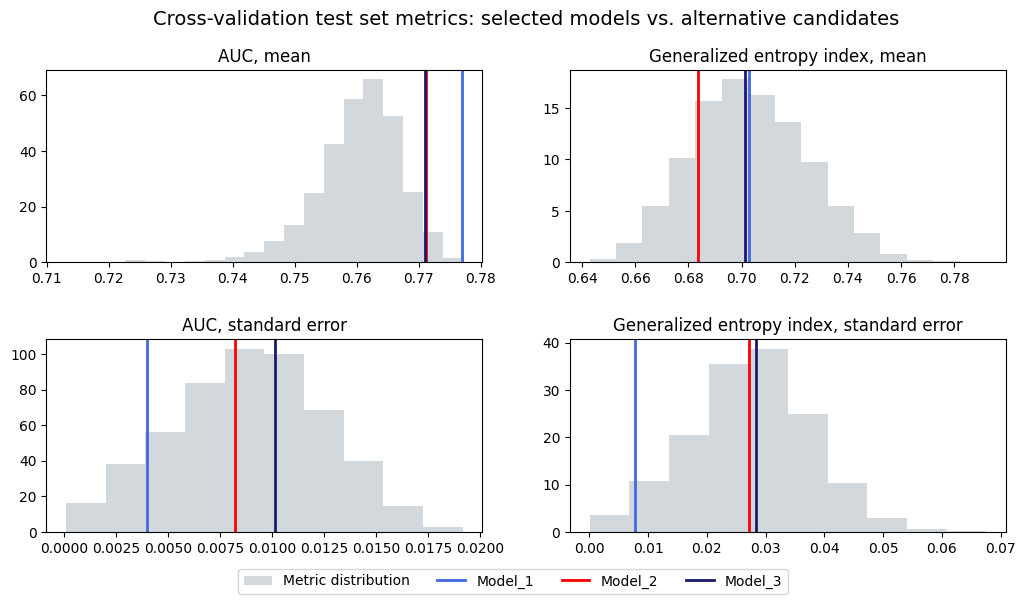

In [70]:
n_row = 2
n_col = 2
figsize = (12, 6)

metrics = ['test_AUC_mean', 'test_Gen entropy_mean', 
           'test_AUC_se', 'test_Gen entropy_se']

metric_names = ['AUC, mean', 
                'Generalized entropy index, mean', 
                'AUC, standard error', 
                'Generalized entropy index, standard error']

bins = [20, 15, 10, 10]

plot_cv_selected_models(model_indices, models_cv_res_, bins,
                        metrics, metric_names, n_row, n_col,
                        figsize)

# Evaluating the performance of the chosen models

In [71]:
selected_models_dic = {
    'Model_1': models_cv_res_.loc[models_cv_res_['index']==model_indices[0], 'MODEL_y'].values[0],
    'Model_2': models_cv_res_.loc[models_cv_res_['index']==model_indices[1], 'MODEL_y'].values[0],
    'Model_3': models_cv_res_.loc[models_cv_res_['index']==model_indices[2], 'MODEL_y'].values[0],
    }

In [72]:
selected_models_dic['Model_1']

['STDNT_FEMALE',
 'HS_GPA_BIN',
 'CURR_GPA',
 'HS_CALC_IND',
 'SNGL_PRNT_IND',
 'STDNT_ASIAN_IND',
 'STDNT_BLACK_IND',
 'STDNT_HSPNC_IND',
 'STDNT_NTV_AMRCN_HWIAN_IND',
 'STDNT_MULTI_ETHNC_IND',
 'STDNT_ETHNC_NAN',
 'SAT_ACT_TOTAL_BIN',
 'ACAD_LOAD',
 'No_grades_at_all',
 'Grade_Overall_I_for_1_and_more_courses',
 'Grade_W_for_1_course',
 'Grade_W_for_2_courses',
 'Grade_W_for_3_and_more_courses',
 'Grade_NR_for_1_and_more_courses']

In [73]:
# For each selected model create a pipeline
model_pipelines = {}
for model_name in selected_models_dic:
    model = selected_models_dic[model_name]
    
    clf = clone(clf_model)

    pipeline = Pipeline(steps=[("imputation", imputation_pipeline), 
                               ("filter_columns", FilterColumns(model)),
                               ("logistic_regression", clf)])
    model_pipelines[model_name] = pipeline   

## Out-of-sample test

In [74]:
fit_test_model(model_pipelines['Model_1'], sample_train, sample_test)[0]

{'auc_train': 0.7888862660031475, 'auc_test': 0.8077584652098024}

In [75]:
fit_test_model(model_pipelines['Model_2'], sample_train, sample_test)[0]

{'auc_train': 0.7917783874214908, 'auc_test': 0.8134870240112804}

In [76]:
fit_test_model(model_pipelines['Model_3'], sample_train, sample_test)[0]

{'auc_train': 0.7895326301163994, 'auc_test': 0.815782472018638}

## Out-of-time test
The assumption is that the model will undergo annual updates, and as such, it should forecast dropout rates for the year ahead

In [77]:
# Number of data points by year
source_df.groupby('YEAR')['STDNT_ID'].count()

YEAR
2015    4162
2016    4576
2017    4238
2018    4168
2019    4249
2020    4234
2021    4495
Name: STDNT_ID, dtype: int64

In [78]:
sample_time_train = source_df[source_df['YEAR']!=2021].copy()
sample_time_test = source_df[source_df['YEAR']==2021].copy()

In [79]:
fit_test_model(model_pipelines['Model_1'], sample_time_train, sample_time_test)[0]

{'auc_train': 0.7765406232272389, 'auc_test': 0.8620155502392344}

In [80]:
fit_test_model(model_pipelines['Model_2'], sample_time_train, sample_time_test)[0]

{'auc_train': 0.7776414615818523, 'auc_test': 0.8679688995215311}

In [81]:
fit_test_model(model_pipelines['Model_3'], sample_time_train, sample_time_test)[0]

{'auc_train': 0.7767117190693347, 'auc_test': 0.8742081339712918}

### Comparison of the dropout rates in the training and test datasets

In [82]:
# Test data set
sample_time_test['y_ENROLLED_1_YEAR_LATER'].mean()

0.021134593993325918

In [83]:
# Train data set
sample_time_train['y_ENROLLED_1_YEAR_LATER'].mean()

0.015452452491512858

### AUC comparison for the training and testing datasets

In [84]:
sample_time_train_imp = imputation_pipeline.fit_transform(sample_time_train, 
                                                          sample_time_train['y_ENROLLED_1_YEAR_LATER'])
sample_time_test_imp = imputation_pipeline.transform(sample_time_test)

In [85]:
factors_time_train_df = univariate_auc(sample_time_train_imp, factors_df, clone(clf_model)) 
factors_time_test_df = univariate_auc(sample_time_test_imp, factors_df, clone(clf_model)) 

In [86]:
factors_time_train_df.merge(factors_time_test_df['AUC'], how='inner', 
                            left_index=True, right_index=True, 
                            suffixes=('_train', '_test'))

,Group,Factor,AUC_train,AUC_test
0,GENDER,STDNT_FEMALE,0.530259,0.504886
1,AGE,STDNT_AGE_BIN,0.512588,0.554667
2,HS_GPA,HS_GPA_BIN,0.543683,0.514761
3,HS_GPA,"[HS_GPA_IsMissing, HS_GPA_Imp]",0.539432,0.554961
4,HS_GPA,HS_GPA_Imp_Interp,0.538551,0.552549
5,CURR_GPA,CURR_GPA,0.709135,0.802720
6,CURR_GPA,CURR_GPA_BIN,0.705782,0.811270
7,HS_CALCULUS,HS_CALC_IND,0.579187,0.654994
8,FAMILY_INCOME,GROSS_FAM_INC,0.589103,0.682519
9,SINGLE_PARENT,SNGL_PRNT_IND,0.559409,0.614133


In [ ]:
plot_dropout_rate(sample_time_train_imp, 'HS_CALC_IND', 'High School Calculus (train)')

In [ ]:
plot_dropout_rate(sample_time_test_imp, 'HS_CALC_IND', 'High School Calculus (test)')

In [ ]:
plot_dropout_rate(source_df[source_df['YEAR']!=2021], 'SNGL_PRNT_IND', 'Single parent (train)')

In [ ]:
plot_dropout_rate(source_df[source_df['YEAR']==2021], 'SNGL_PRNT_IND', 'Single parent (test)')

In [ ]:
plot_dropout_rate(source_df[source_df['YEAR']!=2021], 'CURR_GPA_BIN', 
                  'Current GPA (train)', rotate=True, sort=True)

In [ ]:
plot_dropout_rate(source_df[source_df['YEAR']==2021], 'CURR_GPA_BIN', 
                  'Current GPA (test)', rotate=True, sort=True)

# Evaluation of selected models on the entire source school dataset

## Model 1

In [93]:
fit_test_model(model_pipelines['Model_1'], source_df)[0]

{'auc_train': 0.7933394396700598}

In [94]:
# Check that all coefficients have a correct sign
fit_test_model(model_pipelines['Model_1'], source_df)[1]

,factors,coef
0,STDNT_FEMALE,-0.101226
1,HS_GPA_BIN,0.212918
2,CURR_GPA,-0.722814
3,HS_CALC_IND,-0.516096
4,SNGL_PRNT_IND,0.611165
5,STDNT_ASIAN_IND,-0.223233
6,STDNT_BLACK_IND,0.062336
7,STDNT_HSPNC_IND,0.274813
8,STDNT_NTV_AMRCN_HWIAN_IND,0.555371
9,STDNT_MULTI_ETHNC_IND,-0.131894


## Model 2

In [95]:
fit_test_model(model_pipelines['Model_2'], source_df)[0]

{'auc_train': 0.7976776262488898}

In [96]:
# Check that all coefficients have a correct sign
fit_test_model(model_pipelines['Model_2'], source_df)[1]

,factors,coef
0,STDNT_FEMALE,-0.120444
1,STDNT_AGE_BIN,0.686428
2,HS_GPA_Imp_Interp,-0.071524
3,CURR_GPA,-0.705806
4,HS_CALC_IND,-0.502273
5,GROSS_FAM_INC,0.181235
6,SNGL_PRNT_IND,0.447507
7,STDNT_ASIAN_IND,-0.270629
8,STDNT_BLACK_IND,0.053226
9,STDNT_HSPNC_IND,0.086620


## Model 3

In [97]:
fit_test_model(model_pipelines['Model_3'], source_df)[0]

{'auc_train': 0.7972637095473235}

In [98]:
fit_test_model(model_pipelines['Model_3'], source_df)[1]

,factors,coef
0,STDNT_FEMALE,-0.116688
1,STDNT_AGE_BIN,0.668658
2,HS_GPA_Imp_Interp,-0.082373
3,CURR_GPA,-0.710126
4,HS_CALC_IND,-0.519853
5,GROSS_FAM_INC,0.166424
6,SNGL_PRNT_IND,0.469632
7,STDNT_ETHNC_GRP_CD,0.092652
8,SAT_ACT_TOTAL_BIN,0.332861
9,PRNT_ED_LVL,0.491149


# Data distribution

In [ ]:
# Female
source_df.groupby('STDNT_FEMALE')[['y_ENROLLED_1_YEAR_LATER']].agg(['count', 'sum'])

In [ ]:
# Race
dic = {1: 'White', 2: 'Black', 3: 'Hispanic', 
       4: 'Asian', 5: 'Native Amr', 6: 'Not Indic', 
       7: 'Hawaiian', 0: '2 or More'}

source_df.groupby('STDNT_ETHNC_GRP_CD')[['y_ENROLLED_1_YEAR_LATER']].agg(['count', 'sum'])